# Coding Discussion #5

In [21]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

In [102]:
# Set seed
np.random.seed(1234)

# read in data
data = pd.read_csv("/Users/morganzimmerman/Desktop/GitHub/coding_discussions_ppol564_fall2021/05_coding_discussion/turnout.csv")

# Train-Test split (just using Pandas)
# Break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%)
train = data.sample(frac=.8).reset_index(drop=True)
test = data.drop(train.index).reset_index(drop=True)

# Print off the split count to verify split
# Goal: 1600 entries in training dataset, 400 entries in test dataset
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Preview the top of the data
# train.head()
print(train[1:10])

Training Data: 1600 
Test Data: 400
     id  age  educate  income  vote  white
1   935   72      3.0  0.6765     1      0
2  1034   64     10.0  1.3131     1      1
3   244   80      8.0  1.1839     1      1
4   929   19     14.0  2.9072     1      1
5  1599   72      4.0  0.5813     0      1
6  1838   23     12.0  2.1319     1      1
7  1710   23     16.0  3.2949     1      1
8  1431   52      8.0  5.1229     1      1
9   184   28     14.0  4.0702     1      1


### Calculate Class Probabilities: $Pr(class)$

First, I calculate class probabilities. In other words, what is the probability that an individual will vote and what is the probability that an individual won't vote?

In [81]:
N = train.shape[0]

# Subset the data by class
v1 = train.query("vote == 1")
v0 = train.query("vote == 0")

# Calculate the probability for each class
pr_v_1 = v1.shape[0]/N
pr_v_0 = v0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_v_1}
Pr(vote = 0): {pr_v_0}
""")


Pr(vote = 1): 0.7425
Pr(vote = 0): 0.2575



The probability that an individual votes is 74.2% and the probability that an individual will not vote is 25.8%. This indicates that an individual is roughly 3x more likely to have voted, than to not have voted.

### Calculate Conditional Probabilities: $Pr(data | class)$

*Pr(class|data) = Pr(x1|class) × Pr(x2|class) x ⋯ × Pr(class)*

In [88]:
# Given v == 0
w0_v0 = v0.query("white == 0").shape[0]/v0.shape[0]
w1_v0 = v0.query("white == 1").shape[0]/v0.shape[0]

# Given v == 1
w0_v1 = v1.query("white == 0").shape[0]/v1.shape[0]
w1_v1 = v1.query("white == 1").shape[0]/v1.shape[0]

# Print the probabilities
print(
f"""
Pr(white = 0 |vote = 0): {round(w0_v0,4)}
Pr(white = 1 |vote = 0): {round(w1_v0,4)}
Pr(white = 0 |vote = 1): {round(w0_v1,4)}
Pr(white = 1 |vote = 1): {round(w1_v1,4)}
""")


Pr(white = 0 |vote = 0): 0.2015
Pr(white = 1 |vote = 0): 0.7985
Pr(white = 0 |vote = 1): 0.1313
Pr(white = 1 |vote = 1): 0.8687



To avoid doing the above manual calculations, I define the function calc_probs below after dropping non-binary variables from the datasets. 

In [92]:
# Drop unneeded columns from datasets
train1 = train.drop(columns = ['id', 'age', 'educate', 'income'])
test1 = test.drop(columns = ['id', 'age', 'educate', 'income'])

In [93]:
def calc_probs(data,outcome_var=""):
    '''
    This function calculates class and conditional probabilities for binary data.
    
    Arguments
    ---------
    data: dataset to be used for calculations
    var: the outcome variable that's being conditioned on
    
    Return
    ------
    dictionary (with tuple keys): (variable, it's value, and the outcome that's being conditioned on)
    '''
    # Generate empty dictionary containers
    class_probs = {};cond_probs = {}
    
    # Locate all variables that are not the outcome
    vars = [v for v in data.columns if v != outcome_var]
    
    # Iterate through the class outcomes
    for y, d in data.groupby(outcome_var): 
        
        # Calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        
        # Calculate the conditional probabilities for each variable given the class
        for v in vars:
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,0,y)] = round(pr,4)
            cond_probs[(v,1,y)] = round(1 - pr,4)
            
    # Return calculated values
    return class_probs, cond_probs


# Run the function on the training dataset
class_probs, cond_probs = calc_probs(train1,outcome_var="vote")

# Print results
print("class probabilities -- reported as {class value: class probability}",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities -- reported as {(variable, its value, conditional class value): probability}",end="\n\n")
pp.pprint(cond_probs)

class probabilities -- reported as {class value: class probability}

{0: 0.2575, 1: 0.7425}


conditional probabilities -- reported as {(variable, its value, conditional class value): probability}

{('white', 0, 0): 0.7985,
 ('white', 0, 1): 0.8687,
 ('white', 1, 0): 0.2015,
 ('white', 1, 1): 0.1313}


The results of the class probabilities indicate there's a 25.8% chance an individual won't vote, and a 74.2% chance that an individual will vote. For the conditional probabilities, given that an individual did not vote, there's a 79.9% chance that they are non-white and a 20.1% chance that they are white. Given that an individual did vote, there's a 86.9% chance that they are non-white and a 13.1% chance that they are white.

These are equivalent results to the manually-calculated class probabilities from above.

Now that the probabilities are conveniently stored as dictionaries, I build a prediction function that combs through the observations in the data, calculates probabilities, and makes a class prediction.

In [95]:
def predict(data,class_probs,cond_probs):
    '''
    This function calculates the conditional probability for membership into each class, 
    then returns both the probabilities and the most likely class. 
    
    Arguments
    ---------
    data: dataset to be used for calculations
    class_probs: tuple
    cond_probs: tuple
    
    Return
    ------
    dataframe: pandas dataframe with conditional probabilities and a prediction of the most likely class
    '''
    
    # Generate empty list to store predictions
    store_preds = []
    
    # Iterate through data
    for i,row in data.iterrows():
        
        # Set values
        pr_1 = 1; pr_0 = 1
        
        # Calculate conditional probabilities
        for j in range(1,len(row.index)):
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]    
            
        # Calculate class probabilites
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        
        # Store the predicitions in the list
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])
    
    # Return a dataframe of the results
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run the function on the training dataset
preds = predict(train1, class_probs, cond_probs)

# Print results
# preds.head()
print(preds)

          pr_0     pr_1  pred
0     0.051886  0.09749     1
1     0.205614  0.64501     1
2     0.051886  0.09749     1
3     0.051886  0.09749     1
4     0.051886  0.09749     1
...        ...      ...   ...
1595  0.051886  0.09749     1
1596  0.205614  0.64501     1
1597  0.051886  0.09749     1
1598  0.051886  0.09749     1
1599  0.051886  0.09749     1

[1600 rows x 3 columns]


Next, I calculate predictive accuracy (i.e. how many correct predictions did I make).

In [28]:
# Calculate predictive accuracy of training dataset
accuracy = sum(train.vote == preds.pred)/train.shape[0]
accuracy

0.7425

This value indicates that I have obtained a predictive accuracy of 74.2% on the training data.

Now, I calculate predictive accuracy after running the function on the test dataset.

In [96]:
# Run the function on the test dataset
test_preds = predict(test1, class_probs, cond_probs)

# Calculate predictive accuracy of test dataset
test_accuracy = sum(test1.vote == test_preds.pred)/test1.shape[0]
test_accuracy

0.7

This indicates the model predicts accurately 70% of the time. Both of these models are able to predict with better accuracy than a coin flip (which has a 50% predictive accuracy).

### Naive Bayesian Classifier with Continuous Predictors

The modelling strategy used above assumed that we had binary/discrete predictors (values 0 or 1), which is why white/non-white was the only predictor we were able to analyze. So, I first drop non-continuous variables from the training and test datasets, as well as rearrange and rename the columns.

In [51]:
# Drop columns in train dataset to only include continuous variables as predictors
train2 = train.drop(columns = ['id', 'white', 'age'])
# Rearrange order of colunns
train2 = train2[['vote', 'educate', 'income']]
# Rename columns
train2.columns = ['y', 'x1', 'x2']

# Drop columns in test dataset to only include continuous variables as predictors
test2 = test.drop(columns = ['id', 'white', 'age'])
# Rearrange order of colunns
test2 = test2[['vote', 'educate', 'income']]
# Rename columns
test2.columns = ['y', 'x1', 'x2']

For the continuous variables in this data, I first calculate the conditional mean and standard deviation for each value of the outcome and then calculate the predictions from there for any one of the continuous variables. 

### Calculate Class Probabilities: $Pr(class)$
First, I calculate class probabilities on the train dataset.

In [53]:
# Subset the data by class
y0 = train2.query("y == 0")
y0 = pd.DataFrame(y0)
y1 = train2.query("y == 1")
y1 = pd.DataFrame(y1)

# Calculate the probability for each class
pr_y0 = y0.shape[0]/train2.shape[0]
pr_y1 = y1.shape[0]/train2.shape[0]

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_y0}
Pr(vote = 0): {pr_y1}
""")


Pr(vote = 1): 0.2575
Pr(vote = 0): 0.7425



### Calculate Conditional Means/Standard Deviations

Now, I calculate means and standard deviations for the dataset, and plot normal distributions (explained below).

In [97]:
# Calculate means and standard deviations for the distributions
dist_locs = \
{("x1",1):{'mean':y1.x1.mean(),'sd':y1.x1.std()},
 ("x1",0):{'mean':y0.x1.mean(),'sd':y0.x1.std()},
 ("x2",1):{'mean':y1.x2.mean(),'sd':y1.x2.std()},
 ("x2",0):{'mean':y0.x2.mean(),'sd':y0.x2.std()}
}

# Print results
pp.pprint(dist_locs)

{('x1', 0): {'mean': 10.62864077669903, 'sd': 3.3043810919835317},
 ('x1', 1): {'mean': 12.558922558922559, 'sd': 3.2957141274443202},
 ('x2', 0): {'mean': 2.738161893203883, 'sd': 2.242991372933763},
 ('x2', 1): {'mean': 4.229461952861953, 'sd': 2.848208991067699}}


dict

To view what these different conditional distributions look like, I use seaborn as a way to map a continuous variables into a probability space. The probability density function for the Gaussian (normal) distribution is used to convert continuous values into probabilities. As a reference, I plot the normal distribution below.

In [72]:
st.norm(0, 1).pdf(-1.69) # using the scipy.stats module

0.09565679616352402

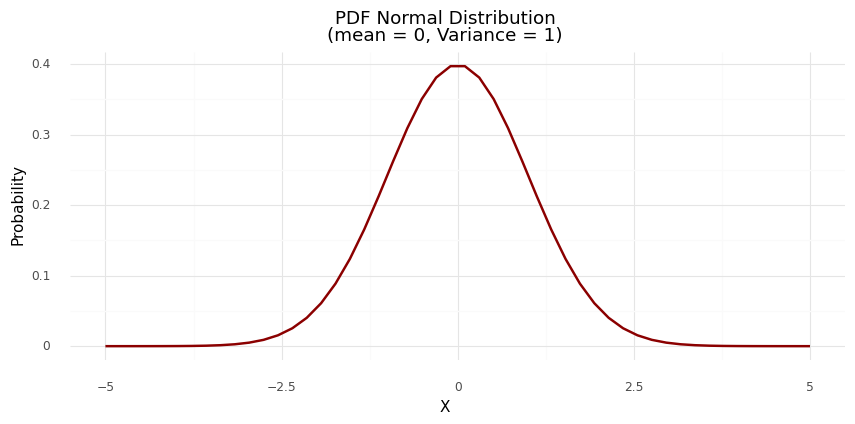

<ggplot: (8782445638391)>

In [73]:
# Calculate the CDF for values in-between the interval of -5 and 5
d = pd.DataFrame([[i,st.norm(0, 1).pdf(i)] for i in np.linspace(-5,5)],
                columns= ["x","y"])

# Plot (with plotnine/ggplot2)
(
    ggplot(d,aes("x","y")) +
    geom_line(color="darkred",size=1) +
    labs(title="PDF Normal Distribution\n(mean = 0, Variance = 1)",
         x = "X",y = "Probability") +
    theme_minimal() +
    theme(figure_size=(10,4))
)

Now, I plot the probability distributions for the continuous variables in our turnout dataset.

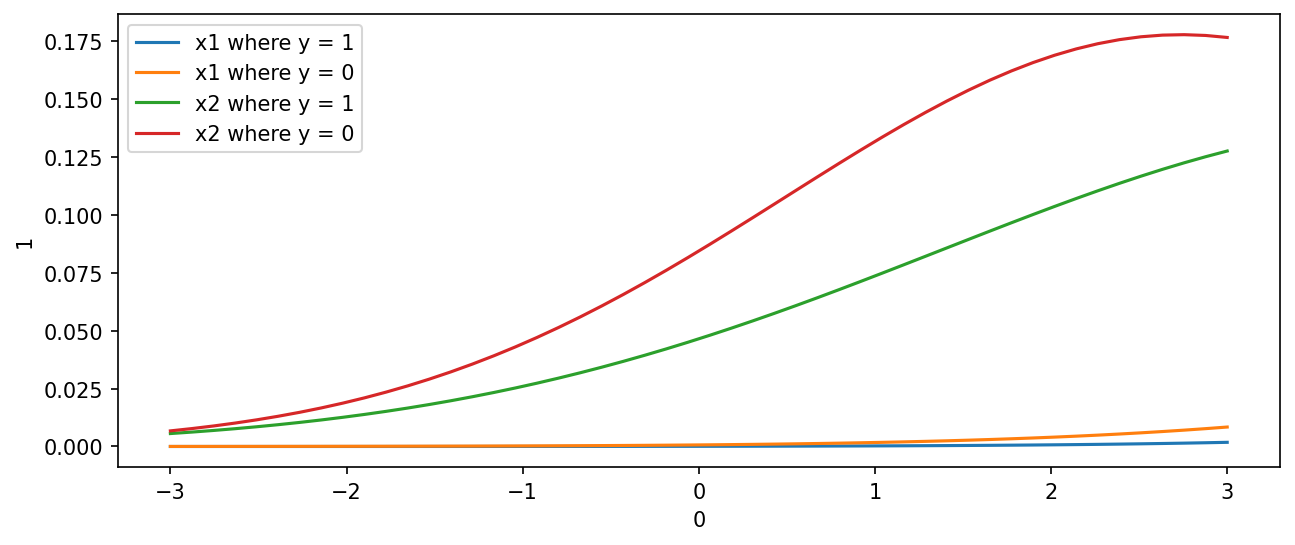

In [56]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-3,3)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

### Predicting a Single Observation

In [61]:
y,x1,x2 = train2.iloc[1,:]
print(y,x1,x2)

1.0 3.0 0.6765


In [62]:
# Prediction for the 1 class
a = st.norm(dist_locs[("x1",1)]['mean'], dist_locs[("x1",1)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",1)]['mean'], dist_locs[("x2",1)]['sd']).pdf(x2)
c = pr_y1
pr_1 = a * b * c

# Prediction for the 0 class
a = st.norm(dist_locs[("x1",0)]['mean'], dist_locs[("x1",0)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",0)]['mean'], dist_locs[("x2",0)]['sd']).pdf(x2)
c = pr_y0
pr_0 = a * b * c

# Print results
print(
f'''
    Pr(y == 1| X): {pr_1}
    Pr(y == 0| X): {pr_0}
''')


    Pr(y == 1| X): 8.617228592896249e-05
    Pr(y == 0| X): 0.0002522684672991984



The probability when $y=1$ is given in scientific notation. The e-05 portion of that value lets us know that there will be 4 leading zeros to the right of the decimal point. When y is 0, we see 3 leading zeros. With that higher probability, we predict that $y=0$.

### Predicting Multiple Observations

In [103]:
def predict(data,dist_locs):
    '''
    This function predicts whether or not an individual with vote for all observations. 
    
    Arguments
    ---------
    data: dataset to be used for calculations
    dist_locs: dictionary of means and standard deviations for each observation
    
    Return
    ------
    dataframe: pandas dataframe with conditional probabilities and a prediction of the most likely class
    '''
    
    # Generate empty list to store predictions
    store_preds = []
    
    # Iterate through data
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        
        # For each observation, calculate mean and standard deviation of the distribution
        for j in range(1,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_y0
        pr_1 *= pr_y1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
        
        # Store the predicitions in the list
        store_preds.append([pr_0,pr_1,class_pred])
    
    # Return a dataframe of the results
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run the function on the training dataset
preds_train = predict(train2,dist_locs)

# Preview predicted output
# preds_train.head(10)
print(preds_train[1:10])

       pr_0      pr_1  pred
1  0.000252  0.000086     0
2  0.004438  0.005513     1
3  0.003170  0.002730     0
4  0.003276  0.010273     1
5  0.000466  0.000190     0
6  0.004891  0.009462     1
7  0.001431  0.006917     1
8  0.002290  0.004604     1
9  0.002755  0.011423     1


To examine the predictive accuracy of the training data:

In [71]:
# Calculate the predictive accuracy of the training data
accuracy_train = sum(train2.y == preds_train.pred)/train2.shape[0]
accuracy_train

0.73125


To examine the predictive accuracy of the test data:

In [70]:
# Run the function on the test dataset
preds_test = predict(test2,dist_locs)

# Calculate the predictive accuracy of the test data
accuracy_test = sum(test2.y == preds_test.pred)/test2.shape[0]
accuracy_test

0.7075

The training model is able to accurately predict whether or not someone votes 73.1% of the time, whereas the test model is able to predict whether or not someone votes 70.8% of the time. Both of these models are still able to predict with better accuracy than a coin flip (which has a 50% predictive accuracy).